# 🎭 Facial Emotion Recognition using Deep Learning

## Project Overview
- **Goal**: Recognize facial expressions from images
- **Dataset**: FER-2013 (Facial Expression Recognition)
- **Technique**: CNN (Convolutional Neural Network) with Transfer Learning
- **Model**: EfficientNetB0 + Custom Classification Head
- **Output**: Confusion Matrix & Emotion Predictions

---

## 7 Emotions Classes:
1. Angry
2. Disgust
3. Fear
4. Happy
5. Sad
6. Surprise
7. Neutral

---
# Part 01 : 
#   -> Import Libraries (prepares the environment)
#   -> Loads TensorFlow, Keras, sklearn, matplotlib, etc.
#   -> Checks if GPU is available .

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ GPU Available: {tf.config.list_physical_devices('GPU')}")

✅ TensorFlow Version: 2.20.0
✅ GPU Available: []


---
# Part 02 : Configuration Settings
#   -> Project Configuration & Hyperparameters
#   -> Defines:

    . dataset paths
    . image size
    . batch size
    . learning rate
    . epochs
    . output folders
    . model save paths

In [2]:
# ============================================
# CONFIGURATION SETTINGS
# ============================================

# Dataset paths (as we know, it divided into 3 parts , train ,val, and test)
TRAIN_DIR = "archive/train"    # Path to training images
VAL_DIR = "archive/val"        # Path to validation images
TEST_DIR = "archive/test"      # Path to test images

# Hyperparameters
IMG_SIZE = (224, 224)          # Image dimensions (required for EfficientNetB0)
BATCH_SIZE = 32                # Number of images per batch (this depends on GPU )
EPOCHS = 100                   # Maximum training epochs - we increase the epoch from 50 to 100
LEARNING_RATE =0.0001          # Initial learning rate (fixed from 0.0001 to 0.0005)(we change it to 1e-5 intead of 0.0005)
                               # after 11 epoch we increase the lr for faster to be 0.0001
NUM_CLASSES = 7                # Number of emotion classes


# Output directories
OUTPUT_DIR = "outputs"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
LOGS_DIR = os.path.join(OUTPUT_DIR, "logs")

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# Model save path
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_emotion_model.h5")
FINAL_MODEL_PATH = os.path.join(MODEL_DIR, "final_emotion_model.h5")

print("✅ Configuration completed!")
print(f"📁 Models will be saved to: {MODEL_DIR}")
print(f"📊 Results will be saved to: {RESULTS_DIR}")

✅ Configuration completed!
📁 Models will be saved to: outputs\models
📊 Results will be saved to: outputs\results


---
# Part 03 : Data Augmentation
#   -> Image Preprocessing & Augmentation
#   -> Uses EfficientNetB0 preprocess_input
#   -> Adds random transformations (rotation, zoom, flip, brightness)
#   -> Makes dataset bigger + reduces overfitting.

In [3]:
# ============================================
# DATA AUGMENTATION CONFIGURATION
# ============================================

preprocess = tf.keras.applications.efficientnet.preprocess_input  # insted of MobileNetV2 we use EfficientNe
# Training data augmentation (to prevent overfitting)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,  # scales to [-1,1]      #2
    rotation_range=30,                 # insted of 20 we increase it to 30
    width_shift_range=0.25,             # Random horizontal shift
    height_shift_range=0.25,            # Random vertical shift
    shear_range=0.25,                   # Random shear transformation
    zoom_range=0.25,                    # Random zoom
    brightness_range=[0.7, 1.3],       # Random brightness adjustment
    horizontal_flip=True,              # Random horizontal flip
    fill_mode='nearest'                # Fill strategy for new pixels
)

# Validation and Test data (only normalization, no augmentation)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess)

print("✅ Data augmentation configured!")

✅ Data augmentation configured!


---
# Part 04 : Load Dataset 
#   -> Data Generators Creation
#   -> Loads images from folders
#   -> Creates train/val/test generators
#   -> Gets class labels

In [4]:
# ============================================
# LOAD DATA FROM DIRECTORIES
# ============================================

# Load data with fixed preprocessing       # 3
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=True, seed=42
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
      target_size=IMG_SIZE, 
      batch_size=BATCH_SIZE,
    class_mode="categorical", 
    shuffle=False
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
      target_size=IMG_SIZE, 
      batch_size=BATCH_SIZE,
    class_mode="categorical",
      shuffle=False
)

# Get emotion labels
emotion_labels = list(train_generator.class_indices.keys())
print(f"✅ Preprocessing fixed!")
print(f"📋 Classes: {emotion_labels}")
print(f"📊 Train: {train_generator.samples} | Val: {val_generator.samples} | Test: {test_generator.samples}")

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
✅ Preprocessing fixed!
📋 Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
📊 Train: 28709 | Val: 3589 | Test: 3589


---
# Part 05 : Class Weights
#   -> Calculates how much attention the model should pay to each emotion .
#   -> Detects rare classes .
#   -> Gives them higher training weight .
#   -> Prevents ignoring small emotions like “fear” or “disgust”.

In [5]:

# ============================================
# CALCULATE CLASS WEIGHTS
# ============================================

classes = np.unique(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',      # Automatically calculates the right weights
    classes=classes,
    y=train_generator.classes
)

class_weight_dict = dict(zip(classes, class_weights))

# Print the weights so you can see them
print("📊 Class Weights (Higher = model pays more attention):")
print("="*50)
for label, weight in zip(emotion_labels, class_weights):
    bar = "█" * int(weight * 5)
    print(f"   {label:12s}: {weight:6.2f}  {bar}")
print("="*50)
print("💡 Higher weight = fewer images = model focuses more on it")

📊 Class Weights (Higher = model pays more attention):
   Angry       :   1.03  █████
   Disgust     :   9.41  ███████████████████████████████████████████████
   Fear        :   1.00  █████
   Happy       :   0.57  ██
   Neutral     :   0.83  ████
   Sad         :   0.85  ████
   Surprise    :   1.29  ██████
💡 Higher weight = fewer images = model focuses more on it


---
# Part 06 : Resume Training
#   -> Continue Training From Checkpoint .
#   -> Loads saved model.
#   -> continues epochs from where you stopped .
#   -> Saves time. No retraining from scratch. 
#   # Important: Run Parts 1-5 first, THEN Part 6, SKIP Parts 7-9, go to Part 10.

In [6]:
# this part to continue training the model (continue the epoch ) from the epoch which we stopped last time on the modle :
# run 1 to 4 only , then run this , don't rebuild the model from scratch (skip 5 to 8 steps)
# so you can after this go to step 9 to the last one 
# ============================================
# RESUME TRAINING FROM CHECKPOINT
# ============================================

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

print("="*60)
print("RESUMING TRAINING FROM SAVED CHECKPOINT")
print("="*60)

# Load the saved model
print("\n📂 Loading saved model...")
model = load_model(BEST_MODEL_PATH)
print(f"✅ Model loaded from: {BEST_MODEL_PATH}")

# Check current performance
print("\n📊 Current model performance:")
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"   Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   Validation loss: {val_loss:.4f}")

# Recompile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
print("✅ Model recompiled")

# Setup callbacks (same as before)
checkpoint = ModelCheckpoint(
    BEST_MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15, # at first the value of it is 10 , we change with 1 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=LOGS_DIR,
    histogram_freq=1
)

callbacks = [checkpoint, early_stop, reduce_lr, tensorboard]

# Resume training
initial_epoch = 15  # ⚠️ UPDATE THIS: The epoch where you stopped (if you enter 2 , so it will start from 3)
total_epochs = 100

print(f"\n🚀 Resuming training...")
print(f"   Starting from epoch: {initial_epoch}")
print(f"   Training until epoch: {total_epochs}")
print(f"   Remaining epochs: {total_epochs - initial_epoch}")
print("="*60 + "\n")

# Continue training from where you left off
history = model.fit(
    train_generator,
    initial_epoch=initial_epoch,
    epochs=total_epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")
print(f"💾 Best model saved to: {BEST_MODEL_PATH}")

RESUMING TRAINING FROM SAVED CHECKPOINT

📂 Loading saved model...


✅ Model loaded from: outputs\models\best_emotion_model.h5

📊 Current model performance:
   Validation accuracy: 0.5737 (57.37%)
   Validation loss: 1.1185
✅ Model recompiled

🚀 Resuming training...
   Starting from epoch: 15
   Training until epoch: 100
   Remaining epochs: 85

Epoch 16/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5372 - loss: 1.2595
Epoch 16: val_loss improved from None to 1.06308, saving model to outputs\models\best_emotion_model.h5



Epoch 16: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 2815s 3s/step - accuracy: 0.5375 - loss: 1.2508 - val_accuracy: 0.6004 - val_loss: 1.0631 - learning_rate: 1.0000e-04
Epoch 17/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5507 - loss: 1.2077
Epoch 17: val_loss improved from 1.06308 to 1.02526, saving model to outputs\models\best_emotion_model.h5



Epoch 17: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 2059s 2s/step - accuracy: 0.5576 - loss: 1.1916 - val_accuracy: 0.6222 - val_loss: 1.0253 - learning_rate: 1.0000e-04
Epoch 18/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5787 - loss: 1.1434
Epoch 18: val_loss improved from 1.02526 to 0.98799, saving model to outputs\models\best_emotion_model.h5



Epoch 18: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1736s 2s/step - accuracy: 0.5821 - loss: 1.1295 - val_accuracy: 0.6328 - val_loss: 0.9880 - learning_rate: 1.0000e-04
Epoch 19/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5978 - loss: 1.0815
Epoch 19: val_loss improved from 0.98799 to 0.98123, saving model to outputs\models\best_emotion_model.h5



Epoch 19: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1527s 2s/step - accuracy: 0.5963 - loss: 1.0879 - val_accuracy: 0.6406 - val_loss: 0.9812 - learning_rate: 1.0000e-04
Epoch 20/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6100 - loss: 1.0478
Epoch 20: val_loss improved from 0.98123 to 0.95869, saving model to outputs\models\best_emotion_model.h5



Epoch 20: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1515s 2s/step - accuracy: 0.6129 - loss: 1.0535 - val_accuracy: 0.6442 - val_loss: 0.9587 - learning_rate: 1.0000e-04
Epoch 21/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6252 - loss: 1.0089
Epoch 21: val_loss improved from 0.95869 to 0.94590, saving model to outputs\models\best_emotion_model.h5



Epoch 21: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1455s 2s/step - accuracy: 0.6237 - loss: 1.0133 - val_accuracy: 0.6500 - val_loss: 0.9459 - learning_rate: 1.0000e-04
Epoch 22/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6379 - loss: 0.9768
Epoch 22: val_loss improved from 0.94590 to 0.94389, saving model to outputs\models\best_emotion_model.h5



Epoch 22: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 2077s 2s/step - accuracy: 0.6380 - loss: 0.9817 - val_accuracy: 0.6498 - val_loss: 0.9439 - learning_rate: 1.0000e-04
Epoch 23/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6446 - loss: 0.9624
Epoch 23: val_loss improved from 0.94389 to 0.91630, saving model to outputs\models\best_emotion_model.h5



Epoch 23: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1631s 2s/step - accuracy: 0.6458 - loss: 0.9560 - val_accuracy: 0.6590 - val_loss: 0.9163 - learning_rate: 1.0000e-04
Epoch 24/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6602 - loss: 0.9271
Epoch 24: val_loss did not improve from 0.91630
898/898 ━━━━━━━━━━━━━━━━━━━━ 1590s 2s/step - accuracy: 0.6568 - loss: 0.9307 - val_accuracy: 0.6567 - val_loss: 0.9428 - learning_rate: 1.0000e-04
Epoch 25/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6652 - loss: 0.9080
Epoch 25: val_loss did not improve from 0.91630
898/898 ━━━━━━━━━━━━━━━━━━━━ 1540s 2s/step - accuracy: 0.6653 - loss: 0.9120 - val_accuracy: 0.6598 - val_loss: 0.9414 - learning_rate: 1.0000e-04
Epoch 26/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6809 - loss: 0.8670
Epoch 26: val_loss did not improve from 0.91630
898/898 ━━━━━━━━━━━━━━━━━━━━ 1374s 2s/step - accuracy: 0.6788 - loss: 0.8770 - va


Epoch 27: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1463s 2s/step - accuracy: 0.6809 - loss: 0.8644 - val_accuracy: 0.6645 - val_loss: 0.9154 - learning_rate: 1.0000e-04
Epoch 28/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6948 - loss: 0.8475
Epoch 28: val_loss improved from 0.91540 to 0.91081, saving model to outputs\models\best_emotion_model.h5



Epoch 28: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1957s 2s/step - accuracy: 0.6923 - loss: 0.8485 - val_accuracy: 0.6682 - val_loss: 0.9108 - learning_rate: 1.0000e-04
Epoch 29/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7116 - loss: 0.7972
Epoch 29: val_loss did not improve from 0.91081
898/898 ━━━━━━━━━━━━━━━━━━━━ 2460s 3s/step - accuracy: 0.7052 - loss: 0.8082 - val_accuracy: 0.6743 - val_loss: 0.9192 - learning_rate: 1.0000e-04
Epoch 30/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7129 - loss: 0.7829
Epoch 30: val_loss did not improve from 0.91081
898/898 ━━━━━━━━━━━━━━━━━━━━ 1780s 2s/step - accuracy: 0.7096 - loss: 0.7943 - val_accuracy: 0.6760 - val_loss: 0.9403 - learning_rate: 1.0000e-04
Epoch 31/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7229 - loss: 0.7580
Epoch 31: val_loss did not improve from 0.91081
898/898 ━━━━━━━━━━━━━━━━━━━━ 1573s 2s/step - accuracy: 0.7204 - loss: 0.7694 - va

KeyboardInterrupt: 

---
# Part 07 : Build New Model from Scratch (EfficientNetB0 + Custom Head)
#   -> loads pretrained EfficientNetB0 .
#   -> freezes early layers .
#   -> adds Dense layers .
#   -> compiles model .
#   -> This is the actual neural network.

In [ ]:

# ---------- BASE MODEL ----------
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights="imagenet"
)

# 

for layer in base_model.layers[:50]:
    layer.trainable = False       # Freeze: general features , we freez first 50 instead of 100

for layer in base_model.layers[50:]:
    layer.trainable = True        # Unfreeze: will learn emotions

# Count frozen vs trainable

print(f"🔒 Frozen layers: {50}")
print(f"🔓 Trainable layers: {len(base_model.layers)-50}")

# ---------- CLASSIFICATION HEAD ----------
x = base_model.output
x = GlobalAveragePooling2D()(x)

# First dense block
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x) # 0.6 instead of 0.5

# Second dense block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # 0.5 instead of 0.4 

# Output: 7 emotions with Softmax
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

# ---------- COMPILE ----------

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=CategoricalCrossentropy(label_smoothing=0.1),   
    metrics=['accuracy']
)

print(f"\n✅ Model built and compiled!")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Loss: CategoricalCrossentropy (label_smoothing=0.1)")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step
🔒 Frozen layers: 50
🔓 Trainable layers: 188

✅ Model built and compiled!
   Learning rate: 1e-05
   Loss: CategoricalCrossentropy (label_smoothing=0.1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,841,642 (18.47 MB)

 Trainable params: 4,775,249 (18.22 MB)

 Non-trainable params: 66,393 (259.35 KB)

In [ ]:

# Load best model
print("📂 Loading best model...")
best_model = load_model(BEST_MODEL_PATH)
print("✅ Model loaded!")

📂 Loading best model...


✅ Model loaded!


---
# Part 08 : Callbacks
#   -> Training Control System .
#   -> save best model .
#   -> early stopping .
#   -> reduce learning rate .
#   -> track progress .
#   -> Makes training smarter automatically .

In [ ]:
# ============================================
# SETUP CALLBACKS
# ============================================

# Save best model
checkpoint = ModelCheckpoint(
    BEST_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Stop if no improvement for 10 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Progress tracker — saves epoch info to JSON
class ProgressTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        progress = {
            'last_epoch': epoch + 1,
            'val_accuracy': float(logs.get('val_accuracy', 0)),
            'val_loss': float(logs.get('val_loss', 0)),
            'last_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(os.path.join(OUTPUT_DIR, 'progress_v2.json'), 'w') as f:
            json.dump(progress, f, indent=4)

# This for compare between the best epoch and the current one to edit hyperparameters like lr . 
callbacks = [
    checkpoint,
    early_stop,
    reduce_lr,
    ProgressTracker()
]

print("✅ Callbacks ready!")

✅ Callbacks ready!


---
# Part 09 : Train Model
#   -> This is where learning happens .

In [ ]:
# ============================================
# TRAIN THE MODEL
# ============================================

print("🚀 Starting V2 training...")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Class weights: Enabled ✅")
print(f"   Label smoothing: 0.1 ✅")
print("="*60 + "\n")

start_time = datetime.now()


# here we train the model 
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weight_dict,   
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()

print("\n" + "="*60)
print("✅ Training complete!")
print(f"⏱️  Duration: {end_time - start_time}")
print(f"📁 Best model saved: {BEST_MODEL_PATH}")
print("="*60)

🚀 Starting V2 training...
   Epochs: 100
   Learning rate: 1e-05
   Class weights: Enabled ✅
   Label smoothing: 0.1 ✅

Epoch 1/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1429 - loss: 3.2616
Epoch 1: val_loss improved from None to 2.20319, saving model to outputs\models\best_emotion_model.h5



Epoch 1: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 2249s 2s/step - accuracy: 0.1477 - loss: 3.1979 - val_accuracy: 0.1864 - val_loss: 2.2032 - learning_rate: 1.0000e-05
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1541 - loss: 3.0986
Epoch 2: val_loss improved from 2.20319 to 2.13539, saving model to outputs\models\best_emotion_model.h5



Epoch 2: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 3461s 4s/step - accuracy: 0.1583 - loss: 3.0649 - val_accuracy: 0.2118 - val_loss: 2.1354 - learning_rate: 1.0000e-05
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1645 - loss: 2.9434
Epoch 3: val_loss improved from 2.13539 to 2.07175, saving model to outputs\models\best_emotion_model.h5



Epoch 3: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1532s 2s/step - accuracy: 0.1660 - loss: 2.9446 - val_accuracy: 0.2374 - val_loss: 2.0717 - learning_rate: 1.0000e-05
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1730 - loss: 2.8877
Epoch 4: val_loss improved from 2.07175 to 2.01660, saving model to outputs\models\best_emotion_model.h5



Epoch 4: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 2356s 3s/step - accuracy: 0.1756 - loss: 2.8702 - val_accuracy: 0.2522 - val_loss: 2.0166 - learning_rate: 1.0000e-05
Epoch 5/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1826 - loss: 2.8332
Epoch 5: val_loss improved from 2.01660 to 1.97186, saving model to outputs\models\best_emotion_model.h5



Epoch 5: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1857s 2s/step - accuracy: 0.1844 - loss: 2.7847 - val_accuracy: 0.2711 - val_loss: 1.9719 - learning_rate: 1.0000e-05
Epoch 6/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1928 - loss: 2.7827
Epoch 6: val_loss improved from 1.97186 to 1.93977, saving model to outputs\models\best_emotion_model.h5



Epoch 6: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1499s 2s/step - accuracy: 0.1943 - loss: 2.7352 - val_accuracy: 0.2839 - val_loss: 1.9398 - learning_rate: 1.0000e-05
Epoch 7/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1996 - loss: 2.7056
Epoch 7: val_loss improved from 1.93977 to 1.90140, saving model to outputs\models\best_emotion_model.h5



Epoch 7: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1892s 2s/step - accuracy: 0.1996 - loss: 2.6950 - val_accuracy: 0.2903 - val_loss: 1.9014 - learning_rate: 1.0000e-05
Epoch 8/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2018 - loss: 2.6335
Epoch 8: val_loss improved from 1.90140 to 1.87626, saving model to outputs\models\best_emotion_model.h5



Epoch 8: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 2611s 3s/step - accuracy: 0.2055 - loss: 2.6315 - val_accuracy: 0.2945 - val_loss: 1.8763 - learning_rate: 1.0000e-05
Epoch 9/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2134 - loss: 2.5742
Epoch 9: val_loss improved from 1.87626 to 1.85046, saving model to outputs\models\best_emotion_model.h5



Epoch 9: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1664s 2s/step - accuracy: 0.2152 - loss: 2.5756 - val_accuracy: 0.3018 - val_loss: 1.8505 - learning_rate: 1.0000e-05
Epoch 10/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2199 - loss: 2.5255
Epoch 10: val_loss improved from 1.85046 to 1.82115, saving model to outputs\models\best_emotion_model.h5



Epoch 10: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1670s 2s/step - accuracy: 0.2222 - loss: 2.5213 - val_accuracy: 0.3115 - val_loss: 1.8212 - learning_rate: 1.0000e-05
Epoch 11/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2251 - loss: 2.5084
Epoch 11: val_loss improved from 1.82115 to 1.79828, saving model to outputs\models\best_emotion_model.h5



Epoch 11: finished saving model to outputs\models\best_emotion_model.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 1629s 2s/step - accuracy: 0.2291 - loss: 2.4657 - val_accuracy: 0.3305 - val_loss: 1.7983 - learning_rate: 1.0000e-05
Epoch 12/100
 62/898 ━━━━━━━━━━━━━━━━━━━━ 22:43 2s/step - accuracy: 0.2392 - loss: 2.4384

KeyboardInterrupt: 

---
# Part 10 : Save Results
#   -> Save Model & History .
#   -> saves training history .
#   -> saves final model .
#   -> keeps results for later use .


In [ ]:
# ============================================
# SAVE TRAINING HISTORY
# ============================================

# Save training history to JSON
history_path = os.path.join(RESULTS_DIR, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history.history, f, indent=4)

print(f"💾 Training history saved to: {history_path}")

# Save final model (not just best)
model.save(FINAL_MODEL_PATH)
print(f"💾 Final model saved to: {FINAL_MODEL_PATH}")


✅ Training completed!
💾 Best model saved to: outputs\models\best_emotion_model.h5


NameError: name 'history' is not defined

---
# Part 11 : Plot Metrics
#   -> Training Visualization .
#   -> plots loss + accuracy curves .
#   -> Helps detect overfitting. .


In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Loss ---
axes[0].plot(history.history['loss'],     label='Training Loss',   linewidth=2, color='#e74c3c')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#3498db')
axes[0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# --- Accuracy ---
axes[1].plot(history.history['accuracy'],     label='Training Accuracy',   linewidth=2, color='#e74c3c')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#3498db')
axes[1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_history_v2.png'), dpi=150, bbox_inches='tight')
plt.show()

print("📊 Final Metrics:")
print(f"   Train Accuracy:      {history.history['accuracy'][-1]*100:.2f}%")
print(f"   Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"   Train Loss:          {history.history['loss'][-1]:.4f}")
print(f"   Validation Loss:     {history.history['val_loss'][-1]:.4f}")

📂 Loading history from: outputs\results\training_history.json


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

---
# Part 12 : Test Evaluation
#   -> Test Set Performance .
#   -> loads best model .
#   -> tests on unseen data .
#   -> real performance measurement.

In [16]:
# ============================================
# EVALUATE ON TEST SET
# ============================================

# Load best model
print("📂 Loading best model...")
best_model = load_model(BEST_MODEL_PATH)

# Evaluate on test set
print("\n🧪 Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print("\n" + "="*60)
print("📊 TEST SET RESULTS:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*60)

📂 Loading best model...



🧪 Evaluating on test set...
113/113 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6732 - loss: 0.8998

📊 TEST SET RESULTS:
   Test Loss: 0.8998
   Test Accuracy: 0.6732 (67.32%)


---
# Part 13 : Predictions
#   -> Generate Predictions .
#   -> predicts labels for test images .


In [9]:
# ============================================
# GENERATE PREDICTIONS
# ============================================

print("🔮 Generating predictions on test set...")

# Get predictions
y_pred = best_model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

print(f"✅ Predictions generated for {len(y_true)} test images")

🔮 Generating predictions on test set...
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 581ms/step
✅ Predictions generated for 3589 test images


---
# Part 14 : Confusion Matrix
#   -> Error Analysis .
#   -> Shows which emotions get confused. .



📊 Generating Confusion Matrix...


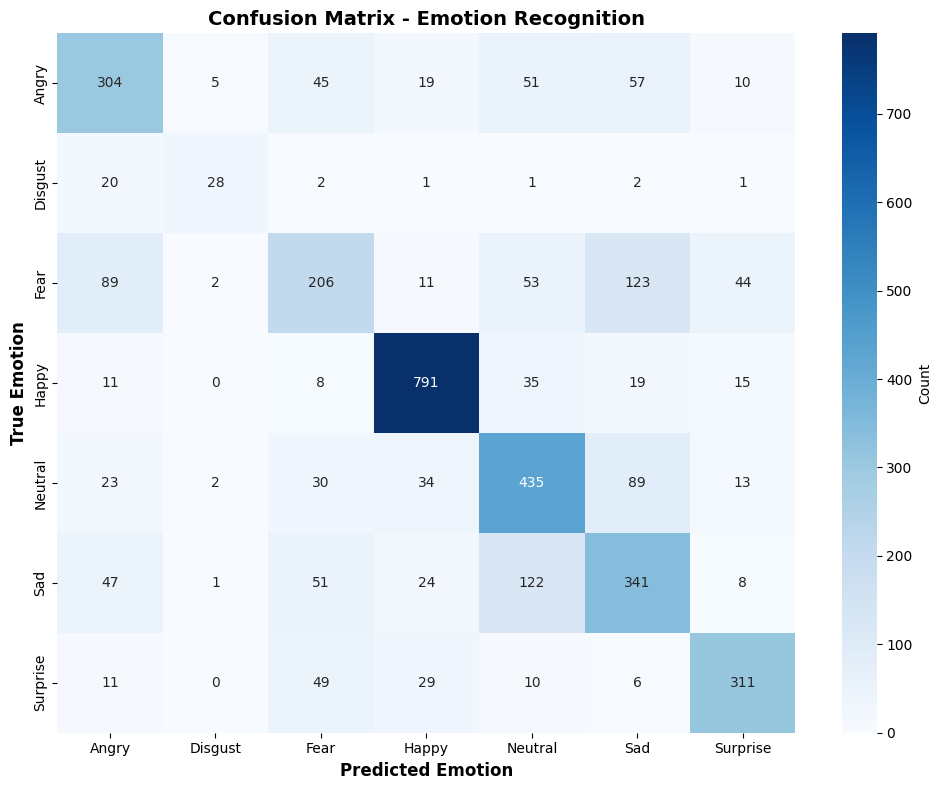

✅ Confusion matrix saved!


In [10]:
# ============================================
# CONFUSION MATRIX
# ============================================

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot confusion matrix heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Emotion', fontsize=12, fontweight='bold')
    plt.ylabel('True Emotion', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix - Emotion Recognition', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    return cm

# Plot confusion matrix
print("\n📊 Generating Confusion Matrix...")
cm = plot_confusion_matrix(y_true, y_pred_classes, emotion_labels)
print("✅ Confusion matrix saved!")

---
# Part 15 : Classification Report
#   -> Precision / Recall / F1 .
#   -> Detailed per-class performance .


In [11]:
# ============================================
# CLASSIFICATION REPORT
# ============================================

print("\n📋 CLASSIFICATION REPORT:")
print("="*60)
report = classification_report(
    y_true, 
    y_pred_classes, 
    target_names=emotion_labels,
    digits=4
)
print(report)

# Save report to file
report_path = os.path.join(RESULTS_DIR, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write("FACIAL EMOTION RECOGNITION - CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n\n")
    f.write(report)
    f.write("\n" + "="*60 + "\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")

print(f"\n💾 Classification report saved to: {report_path}")


📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Angry     0.6020    0.6191    0.6104       491
     Disgust     0.7368    0.5091    0.6022        55
        Fear     0.5269    0.3902    0.4483       528
       Happy     0.8702    0.8999    0.8848       879
     Neutral     0.6153    0.6949    0.6527       626
         Sad     0.5353    0.5741    0.5540       594
    Surprise     0.7736    0.7476    0.7604       416

    accuracy                         0.6732      3589
   macro avg     0.6657    0.6335    0.6447      3589
weighted avg     0.6699    0.6732    0.6691      3589


💾 Classification report saved to: outputs\results\classification_report.txt


---
# Part 16 : Per-Class Accuracy
#   -> Per Emotion Accuracy Visualization .
#   -> Bar chart for each emotion .


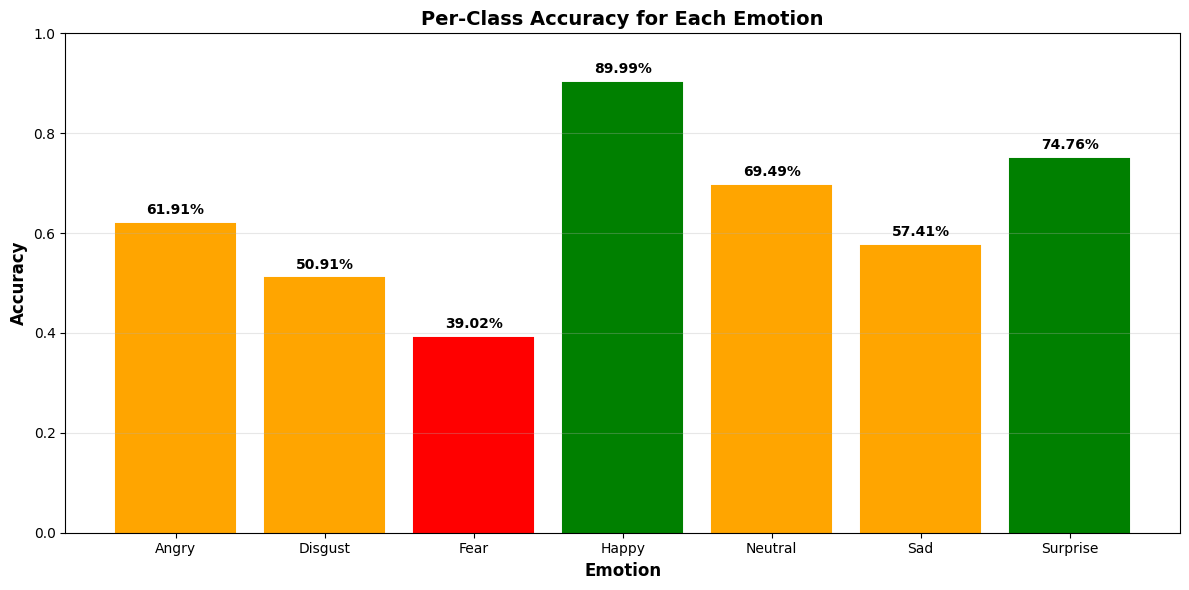


📊 Per-Class Accuracy:
   Angry       : 0.6191 (61.91%)
   Disgust     : 0.5091 (50.91%)
   Fear        : 0.3902 (39.02%)
   Happy       : 0.8999 (89.99%)
   Neutral     : 0.6949 (69.49%)
   Sad         : 0.5741 (57.41%)
   Surprise    : 0.7476 (74.76%)


In [12]:
# ============================================
# PER-CLASS ACCURACY
# ============================================

def plot_per_class_accuracy(cm, labels):
    """
    Calculate and plot accuracy for each emotion class
    """
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, per_class_acc, color='skyblue', edgecolor='navy', linewidth=1.5)
    
    # Color bars based on accuracy
    for i, bar in enumerate(bars):
        if per_class_acc[i] >= 0.7:
            bar.set_color('green')
        elif per_class_acc[i] >= 0.5:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    plt.xlabel('Emotion', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Per-Class Accuracy for Each Emotion', fontsize=14, fontweight='bold')
    plt.ylim([0, 1])
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(per_class_acc):
        plt.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'per_class_accuracy.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print per-class accuracy
    print("\n📊 Per-Class Accuracy:")
    print("="*40)
    for label, acc in zip(labels, per_class_acc):
        print(f"   {label:12s}: {acc:.4f} ({acc*100:.2f}%)")
    print("="*40)

# Plot per-class accuracy
plot_per_class_accuracy(cm, emotion_labels)

---
# Part 17 : Single Image Prediction
#   -> Inference Function .
#   -> Predict ONE image from my PC .


In [12]:
# ============================================
# PREDICTION FUNCTION FOR NEW IMAGES (FINAL)
# ============================================

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# ✅ MUST match EfficientNet training
preprocess = tf.keras.applications.efficientnet.preprocess_input


def predict_emotion(image_path, model, show_confidence=True):

    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=IMG_SIZE
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # ✅ correct preprocessing
    img_array = preprocess(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)

    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    predicted_emotion = emotion_labels[predicted_class]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(img)
    axes[0].set_title(
        f"Predicted: {predicted_emotion}\nConfidence: {confidence:.2%}",
        fontweight='bold'
    )
    axes[0].axis('off')

    if show_confidence:
        axes[1].barh(emotion_labels, predictions[0])
        axes[1].set_xlim([0, 1])
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nPrediction: {predicted_emotion} ({confidence:.2%})")

    return predicted_emotion, confidence


# This code for convert colored image to grayscale


In [31]:
import tensorflow as tf

img = tf.io.read_file( r"D:\Fifth year\Deep learning\Lab\Project - Copy\ImgTest\SamerS.jpeg")
img = tf.image.decode_jpeg(img, channels=3)

gray = tf.image.rgb_to_grayscale(img)

tf.keras.utils.save_img("graySamerS.jpg", gray)


---
# Part 18 : Test One Sample
#   -> Example Prediction .
#   -> Quick demo of part 17 .
#   -> Tests the prediction function on one image you specify .


🔮 Testing prediction on image 1 (SamerH.jpeg)...



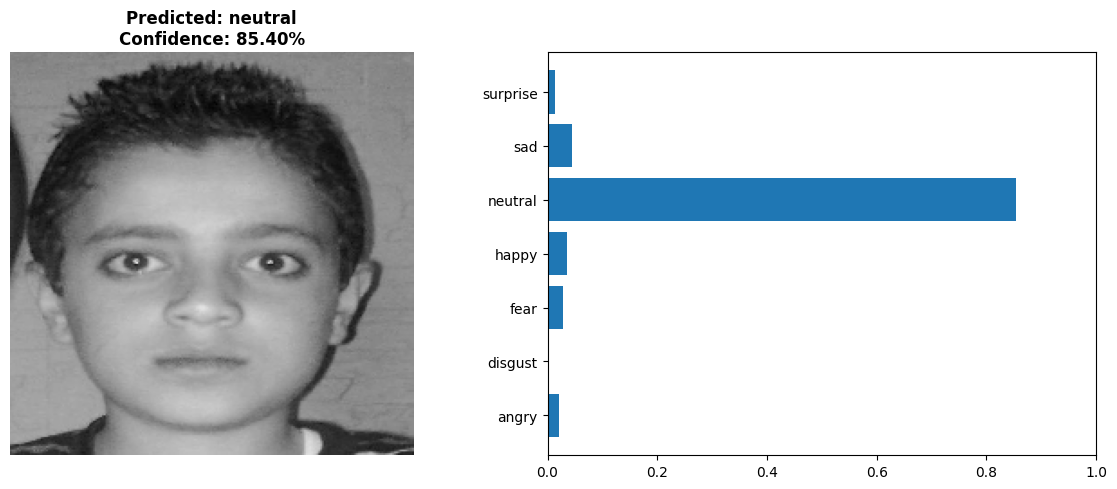


Prediction: neutral (85.40%)


🔮 Testing prediction on image 2 (SamerS.jpeg)...



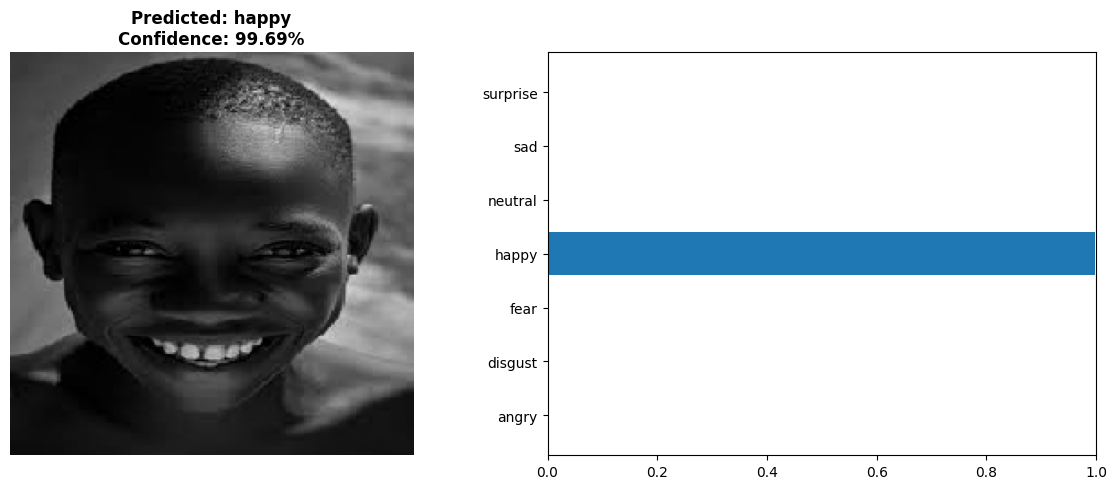


Prediction: happy (99.69%)
🔮 Testing prediction on image 3 (SamerH.jpeg)...



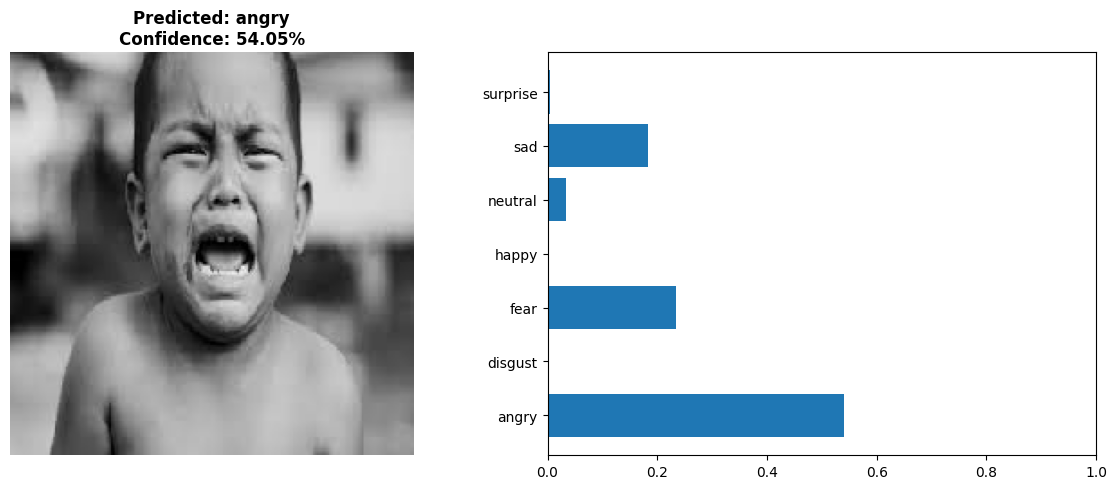


Prediction: angry (54.05%)


🔮 Testing prediction on image 1 (SamerH.jpeg)...



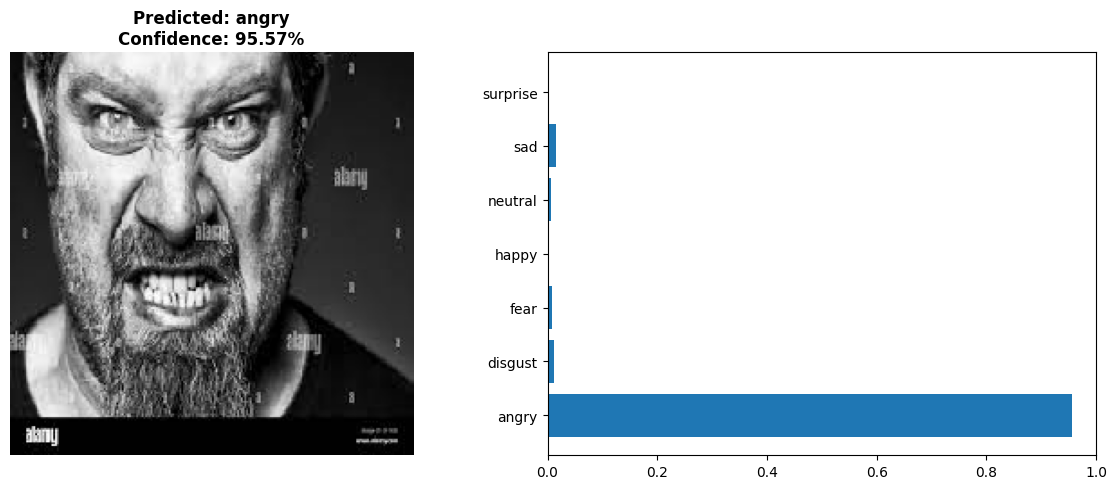


Prediction: angry (95.57%)


🔮 Testing prediction on image 1 (SamerH.jpeg)...



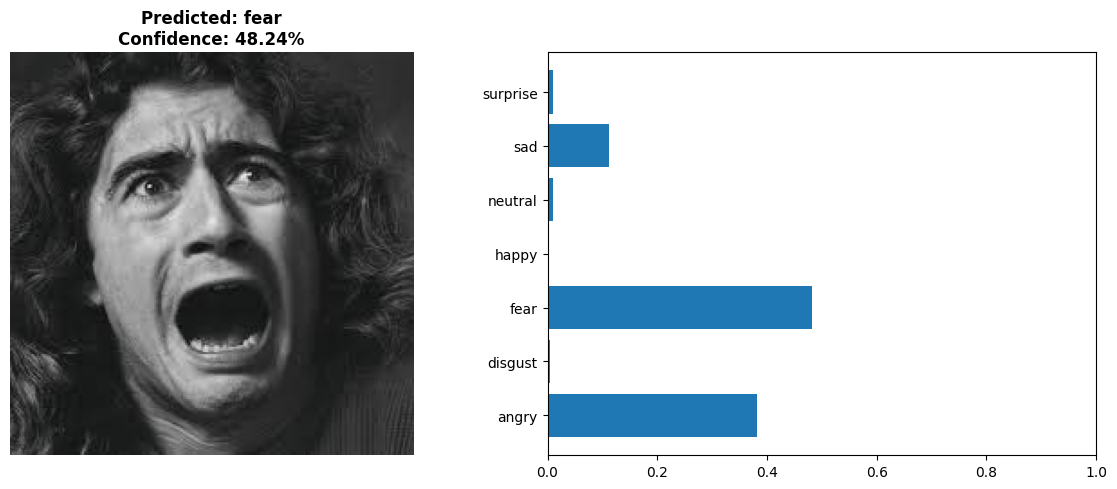


Prediction: fear (48.24%)




In [14]:
# ============================================
# TEST PREDICTIONS ON SAMPLE IMAGES (FIXED)
# ============================================

# Your image paths
my_image_1 = r"D:\Fifth year\Deep learning\Lab\Project - Copy\ImgTest\graySamerS.jpg"
my_image_2 = r"D:\Fifth year\Deep learning\Lab\Project - Copy\ImgTest\HappyBoy.jpg"
my_image_3 = r"D:\Fifth year\Deep learning\Lab\Project - Copy\ImgTest\sadboy.jpg"
my_image_4 = r"D:\Fifth year\Deep learning\Lab\Project - Copy\ImgTest\angryman.jpg"
my_image_5 = r"D:\Fifth year\Deep learning\Lab\Project - Copy\ImgTest\fear girls.jpg"

# ✅ FIX: Test image 1 (check correct variable)
if os.path.exists(my_image_1):
    print("🔮 Testing prediction on image 1 (SamerH.jpeg)...\n")
    predicted_emotion, confidence = predict_emotion(
        my_image_1, 
        best_model, 
        show_confidence=True
    )
else:
    print(f"⚠️ Image not found: {my_image_1}")

print("\n" + "="*60 + "\n")

# ✅ FIX: Test image 2
if os.path.exists(my_image_3):
    print("🔮 Testing prediction on image 2 (SamerS.jpeg)...\n")
    predicted_emotion, confidence = predict_emotion(
        my_image_2, 
        best_model, 
        show_confidence=True
    )
else:
    print(f"⚠️ Image not found: {my_image_3}")


# ✅ FIX: Test image 3 (check correct variable)
if os.path.exists(my_image_3):
    print("🔮 Testing prediction on image 3 (SamerH.jpeg)...\n")
    predicted_emotion, confidence = predict_emotion(
        my_image_3, 
        best_model, 
        show_confidence=True
    )
else:
    print(f"⚠️ Image not found: {my_image_3}")

print("\n" + "="*60 + "\n")



# ✅ FIX: Test image 4 (check correct variable)
if os.path.exists(my_image_4):
    print("🔮 Testing prediction on image 1 (SamerH.jpeg)...\n")
    predicted_emotion, confidence = predict_emotion(
        my_image_4, 
        best_model, 
        show_confidence=True
    )
else:
    print(f"⚠️ Image not found: {my_image_4}")

print("\n" + "="*60 + "\n")


# ✅ FIX: Test image 5
if os.path.exists(my_image_5):
    print("🔮 Testing prediction on image 1 (SamerH.jpeg)...\n")
    predicted_emotion, confidence = predict_emotion(
        my_image_5, 
        best_model, 
        show_confidence=True
    )
else:
    print(f"⚠️ Image not found: {my_image_5}")

print("\n" + "="*60 + "\n")


---
# Part 19 : Multiple Predictions
#   -> Visual Batch Testing .
#   -> Shows many predictions at once.
#   -> Green = correct, Red = wrong.


🎨 Visualizing predictions on test images...



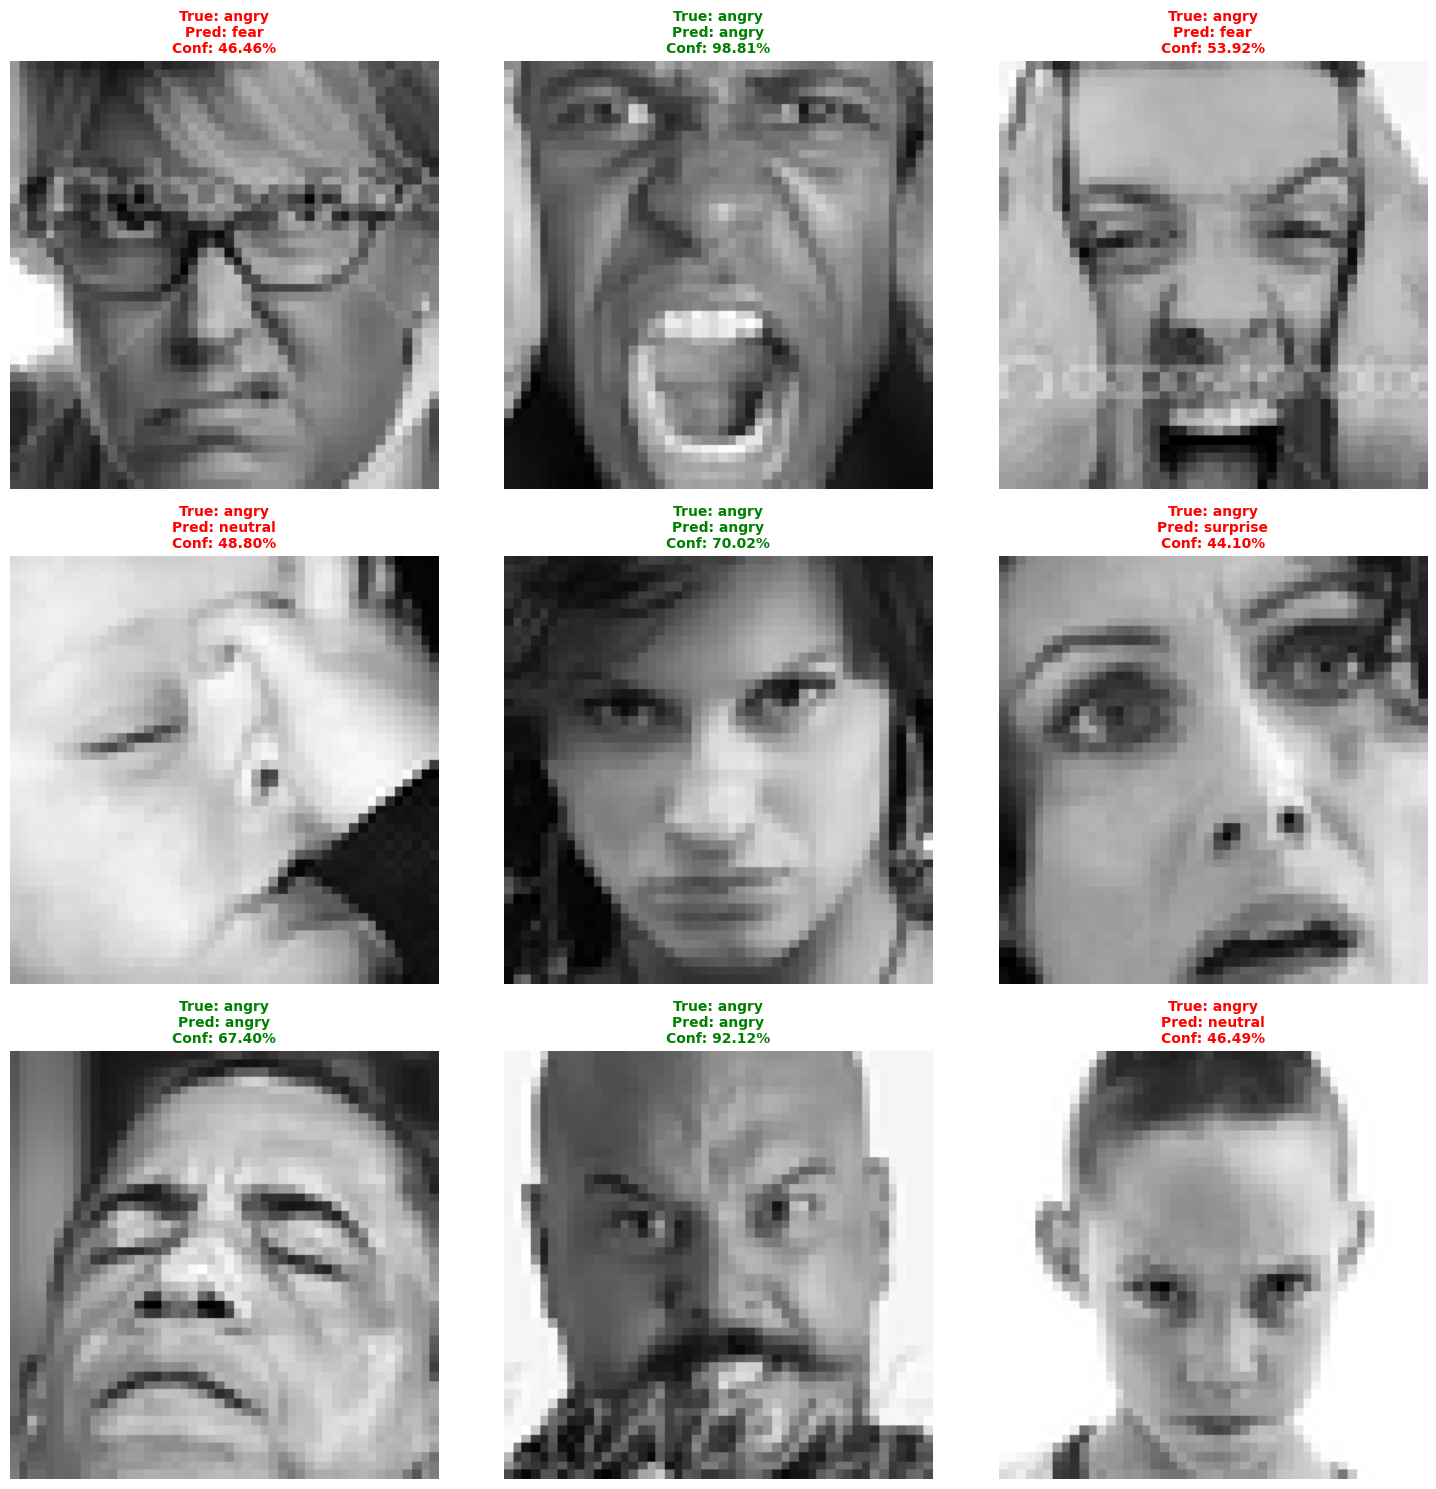

✅ Visualization saved to: outputs\results\prediction_samples.png


In [17]:
# ============================================
# VISUALIZE PREDICTIONS ON MULTIPLE IMAGES 
# ============================================

# ✅ Make sure emotion_labels is defined
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def visualize_predictions(generator, model, num_images=9):
    """
    Visualize predictions on multiple images from the test set
    """
    # Get a batch of images
    images, true_labels = next(generator)
    
    # Make predictions
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)
    
    # ✅ FIX: Convert preprocessed images back to displayable format
    def preprocess_inverse(img):
        """Convert EfficientNet preprocessed image back to [0, 1] for display"""
        img_display = img.copy()
        
        # Rescale from preprocessed range to [0, 1]
        img_min = img_display.min()
        img_max = img_display.max()
        if img_max > img_min:
            img_display = (img_display - img_min) / (img_max - img_min)
        
        return np.clip(img_display, 0, 1)
    
    # Plot
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        
        # ✅ Convert image to displayable format
        display_img = preprocess_inverse(images[i])
        plt.imshow(display_img)
        
        true_emotion = emotion_labels[true_classes[i]]
        pred_emotion = emotion_labels[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]]
        
        # Color: green if correct, red if wrong
        color = 'green' if true_classes[i] == predicted_classes[i] else 'red'
        
        plt.title(
            f"True: {true_emotion}\nPred: {pred_emotion}\nConf: {confidence:.2%}",
            color=color,
            fontweight='bold',
            fontsize=10
        )
        plt.axis('off')
    
    plt.tight_layout()
    plot_path = os.path.join(RESULTS_DIR, 'prediction_samples.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualization saved to: {plot_path}")

# Visualize predictions
print("🎨 Visualizing predictions on test images...\n")
visualize_predictions(test_generator, best_model, num_images=9)